In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import en_core_web_sm
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel


In [4]:
data=pd.read_csv('Data/speeches.csv')
data.head()

,Unnamed: 0,Speaker,Title,Links,Delivered,Speeches
0,0,"Martin Luther King, Jr.",I Have A Dream,speeches/mlkihaveadream.htm,"delivered \r\n 28 August 1963, at the Lin...",I am happy to join with you today in what will...
1,1,John Fitzgerald Kennedy,Inaugural Address,speeches/jfkinaugural.htm,"delivered 20 January 1961, \r\nWashington, D.C.","Vice President Johnson, Mr. Speaker, Mr. Chief..."
2,2,Franklin Delano Roosevelt,First Inaugural Address,speeches/fdrfirstinaugural.html,Delivered 4 March 1933,"President Hoover, Mr. Chief Justice, my friend..."
3,3,Franklin Delano Roosevelt,Pearl Harbor Address to the Nation,speeches/fdrpearlharbor.htm,"delivered 8 \r\nDecember 1941, Washington, D.C.","Mr. Vice President, Mr. Speaker, Members of th..."
4,4,Barbara Charline Jordan,1976 DNC Keynote Address,speeches/barbarajordan1976dnc.html,"delivered 12 July 1976, New York, NY",Thank you ladies and gentlemen for a very warm...


In [6]:
scripts=data['Speeches']
scripts.head()

0    I am happy to join with you today in what will...
1    Vice President Johnson, Mr. Speaker, Mr. Chief...
2    President Hoover, Mr. Chief Justice, my friend...
3    Mr. Vice President, Mr. Speaker, Members of th...
4    Thank you ladies and gentlemen for a very warm...
Name: Speeches, dtype: object

In [10]:
#Load SpaCy English Model
nlp = en_core_web_sm.load()

#Tags to remove
extags = ['PRON','CCONJ','PUNCT','PART','DET','ADP','NUM','SYM','SPACE']

tokens=[]
for speech in nlp.pipe(scripts):
    scr_tok = [token.lemma_.lower() for token in speech if token.pos_ not in extags and not token.is_stop and token.is_alpha]
    tokens.append(scr_tok)
data['tokens'] = tokens
data['tokens']


0     [happy, join, today, history, great, demonstra...
1     [vice, president, johnson, speaker, chief, jus...
2     [president, hoover, chief, justice, friend, da...
3     [vice, president, speaker, member, senate, hou...
4     [thank, lady, gentleman, warm, reception, year...
                            ...                        
95    [speaker, president, member, house, member, se...
96    [senator, mccarthy, chairman, view, request, s...
97    [president, fellow, delegate, long, meticulous...
98    [chancellor, vice, chancellor, professor, robe...
99    [thank, senator, fulbright, senator, javits, s...
Name: tokens, Length: 100, dtype: object

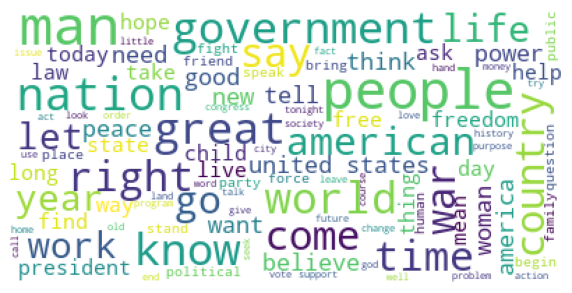

In [55]:
text = []
for i in range(0,99):
    text = text + data['tokens'][i]
text = " ".join(text)
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      max_font_size=40,
                      random_state=42).generate(text)
fig = plt.figure(1,figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off');

In [62]:
dict = Dictionary(data['tokens'])
#Filter out tokens that appear in less than 5 speeches, and tokens that appear in more than 70% of speeches since they are too general. Keep the top 1000 most frequent tokens
dict.filter_extremes(no_below=5,no_above=0.7,keep_n=1000)

#Convert token counts into bag of words (BoW) corpus
corpus = [dict.doc2bow(speech) for speech in data['tokens']]

In [67]:
#Construct and train unsupervised LDA model
topics=[]
score=[]
for i in range(1,20,1):
    model = LdaMulticore(corpus=corpus, id2word=dict, iterations=50, num_topics=i, workers=4, passes=10)
    #LdamultiCore uses multiple cores to speed up model training, use with caution if you have a weaker PC! (Find your max number of cores with ctrl+shift+esc, under CPU)
    cm = CoherenceModel(model=model, corpus=corpus, dictionary=dict, coherence='u_mass')

    topics.append(i)
    score.append(cm.get_coherence())
    

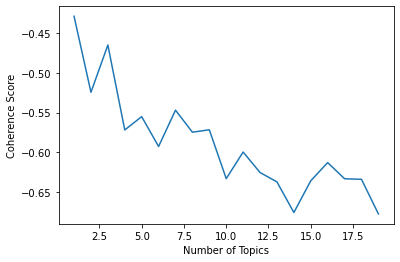

In [68]:
_=plt.plot(topics,score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()